# Pytorch sar ship detection


In this notebook I enabled the GPU and the Internet access (needed for the pre-trained weights). We can not use Internet during inference, so I'll create another notebook for commiting. Stay tuned!

You can find the [inference notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)

- FasterRCNN from torchvision
- Use Resnet50 backbone
- Albumentation enabled (simple flip for now)


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "/content/gdrive/MyDrive/DTU/Semester 1/Deep Learning/Project/"

/content/gdrive/MyDrive/DTU/Semester 1/Deep Learning/Project


In [3]:
!pip install albumentations==0.4.6

#Load data and stuff

In [14]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = 'ship_dataset_v0' # the dataset folder in the root folder
DIR_TRAIN = f'{DIR_INPUT}/train' # train images folder inside the dataset folder

In [15]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv') # train.csv
train_df.shape

(5161, 5)

In [16]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [17]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-500:]
train_ids = image_ids[:-500]

In [18]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [19]:
valid_df.shape, train_df.shape

((664, 8), (4497, 8))

In [20]:
class SSDD(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        #target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [21]:
# Albumentations
# convert numpy image array to torch.Tensor
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Dataloader and Averager


In [22]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = SSDD(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = SSDD(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4, #16
    shuffle=False,
    num_workers=2, #4
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2, #4
    collate_fn=collate_fn
)

In [24]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cpu")

# Sample

In [25]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [26]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


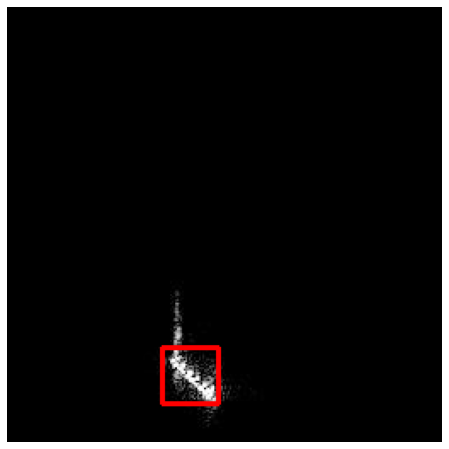

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)

#Evaluation metrics


In [41]:
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcualte intersection over union
def calc_iou( gt_bbox, pred_bbox):
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [42]:
def get_model_scores(pred_boxes):
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

In [43]:
def calc_precision_recall(image_results):
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [44]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        return {'true_positive':0, 'false_positive':0, 'false_negative':0}
    if len(all_gt_indices)==0:
        return {'true_positive':0, 'false_positive':0, 'false_negative':0}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        return {'true_positive':0, 'false_positive':0, 'false_negative':0}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [45]:
def  get_avg_precision_at_iou(gt_boxes, pred_bb, toprint=True, iou_thr=0.5):
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())
    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_bb)
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}

    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        if toprint:
          print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:
               
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        # calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []

    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            if toprint:
              print(recalls,"Recall")
              print(recall_level,"Recall Level")
              print(args, "Args")
              print(prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)

    avg_prec = np.mean(prec_at_rec)
    return {
        'avg_prec': avg_prec,
        'prec_at_rec': prec_at_rec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [46]:
def get_outputs(model, imgs):
  outputs = model(imgs)
  outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
  return outputs

def get_outputs_eval(model, imgs, img_ids):
  outputs = model(imgs)
  outputs_eval = {}
  for i in range(len(img_ids)):
    image_id = img_ids[i]
    boxes = outputs[i]['boxes'].cpu().detach().numpy().tolist()
    scores = outputs[i]['scores'].cpu().detach().numpy().tolist()
    outputs_eval[image_id] = {'boxes': boxes, 'scores': scores}
  return outputs_eval

def get_targets_eval(img_ids, targets):
  targets_eval = {}
  for i in range(len(img_ids)):
    image_id = img_ids[i]
    boxes = targets[i]['boxes'].cpu().detach().numpy().tolist()
    targets_eval[image_id] = boxes
  return targets_eval

In [47]:
def getAveragePrecision(model):
  model_precisions = []

  targets_eval = {}
  predicted_eval = {}

  for images, targets, image_ids in valid_data_loader:

      targets_batch = get_targets_eval(image_ids, targets)
      for key, value in targets_batch.items():
        targets_eval[key] = value

      images = list(img.to(device) for img in images)
      outputs_model = get_outputs_eval(model, images, image_ids)

      for key, value in outputs_model.items():
        predicted_eval[key] = value

  for threshold in np.linspace(0.5, 0.95, 10):
      evaluation_model = get_avg_precision_at_iou(targets_eval, predicted_eval, False, threshold)
      #print(evaluation_model)
      model_precisions.append(evaluation_model['avg_prec'])

  return np.mean(model_precisions)

# Train

In [35]:
# load a model; pre-trained on COCO if pretrained=True
model_resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True, trainable_backbone_layers=2)
model_mobilenet = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, pretrained_backbone=True, trainable_backbone_layers=2)
model_mobilenet_320 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, pretrained_backbone=True, trainable_backbone_layers=2)

In [36]:
num_classes = 2  # 1 class (ship) + background

# get number of input features for the classifier
in_features_resnet = model_resnet.roi_heads.box_predictor.cls_score.in_features
in_features_mobilenet = model_mobilenet.roi_heads.box_predictor.cls_score.in_features
in_features_mobilenet_320 = model_mobilenet_320.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_features_resnet, num_classes)
model_mobilenet.roi_heads.box_predictor = FastRCNNPredictor(in_features_mobilenet, num_classes)
model_mobilenet_320.roi_heads.box_predictor = FastRCNNPredictor(in_features_mobilenet_320, num_classes)

In [37]:
model_resnet.to(device)
model_mobilenet.to(device)
model_mobilenet_320.to(device)

params_resnet = [p for p in model_resnet.parameters() if p.requires_grad]
params_mobilenet = [p for p in model_mobilenet.parameters() if p.requires_grad]
params_mobilenet_320 = [p for p in model_mobilenet_320.parameters() if p.requires_grad]

optimizer_resnet = torch.optim.SGD(params_resnet, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer_mobilenet = torch.optim.SGD(params_mobilenet, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer_mobilenet_320 = torch.optim.SGD(params_mobilenet_320, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [38]:
#Load saved models
model_resnet.load_state_dict(torch.load('fasterrcnn_resnet.pth', map_location=device))
model_mobilenet.load_state_dict(torch.load('fasterrcnn_mobilenet.pth', map_location=device))
model_mobilenet_320.load_state_dict(torch.load('fasterrcnn_mobilenet_320.pth', map_location=device))

<All keys matched successfully>

In [29]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [30]:
def train(model, optimizer, num_epochs):
  loss_hist = Averager()
  itr = 1
  aps = {}
  aps_x = []
  aps_y = []
  loss_x = []
  loss_y = []

  for epoch in range(num_epochs):
      loss_hist.reset()
      aps[epoch] = []

      for images, targets, image_ids in train_data_loader:
          model.train()
          
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets)

          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()

          loss_hist.send(loss_value)

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          if itr % 25 == 0:
              model.eval()
              ap = getAveragePrecision(model)
              aps[epoch].append(ap)
              aps_y.append(ap)
              aps_x.append(itr)
              loss_y.append(loss_hist.value)
              loss_x.append(itr)
              print(f"Iteration #{itr} loss: {loss_value}, validation ap: {ap}")

          itr += 1

      print(f"Epoch #{epoch} loss: {loss_value}, validation ap: {np.mean(aps[epoch])}") 

  plt.subplot(2, 1, 1)
  plt.plot(aps_x, aps_y)
  plt.xlabel('Iteration')
  plt.ylabel('mAP@[.5:.95]')
  plt.show()

  plt.subplot(2, 1, 2)   
  plt.plot(loss_x, loss_y)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.show()

In [ ]:
train(model_resnet, optimizer_resnet, 5)

# Trained models

In [48]:
images, targets, image_ids = next(iter(valid_data_loader))

In [49]:
images = list(img.to(device) for img in images)
targets_eval = get_targets_eval(image_ids, targets)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [50]:
sample_ind = 3 # Batch size is 8 -> 0..7
sample_boxes = targets[sample_ind]['boxes'].cpu().numpy().astype(np.int32)
sample = images[sample_ind].permute(1,2,0).cpu().numpy()

In [51]:
model_resnet.eval()
model_mobilenet.eval()
model_mobilenet_320.eval()

outputs_resnet = get_outputs(model_resnet, images)
outputs_mobilenet = get_outputs(model_mobilenet, images)
outputs_mobilenet_320 = get_outputs(model_mobilenet_320, images)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [52]:
sample_predicted_boxes_resnet = outputs_resnet[sample_ind]['boxes'].cpu().detach().numpy().astype(np.int32)
sample_predicted_boxes_scores_resnet = outputs_resnet[sample_ind]['scores'].cpu().detach().numpy()

sample_predicted_boxes_mobilenet = outputs_mobilenet[sample_ind]['boxes'].cpu().detach().numpy().astype(np.int32)
sample_predicted_boxes_scores_mobilenet = outputs_mobilenet[sample_ind]['scores'].cpu().detach().numpy()

sample_predicted_boxes_mobilenet_320 = outputs_mobilenet_320[sample_ind]['boxes'].cpu().detach().numpy().astype(np.int32)
sample_predicted_boxes_scores_mobilenet_320 = outputs_mobilenet_320[sample_ind]['scores'].cpu().detach().numpy()

In [97]:
def img_with_boxes(img, boxes, predicted_boxes, predicted_scores):
  img_copy = img.copy()
  for box in boxes:
      cv2.rectangle(img_copy,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (220, 0, 0), 2)

  for i in range(len(predicted_boxes)):
      box = predicted_boxes[i]
      thickness = 2 if predicted_scores[i] > 0.9 else 1 
      cv2.rectangle(img_copy,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (0, 220, 0), thickness)
  return img_copy
      
def plot_boxes(img, boxes, predicted_boxes, predicted_scores):
  plt.figure(figsize=(16,10))
  plt.imshow(img_with_boxes(img, boxes, predicted_boxes, predicted_scores))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


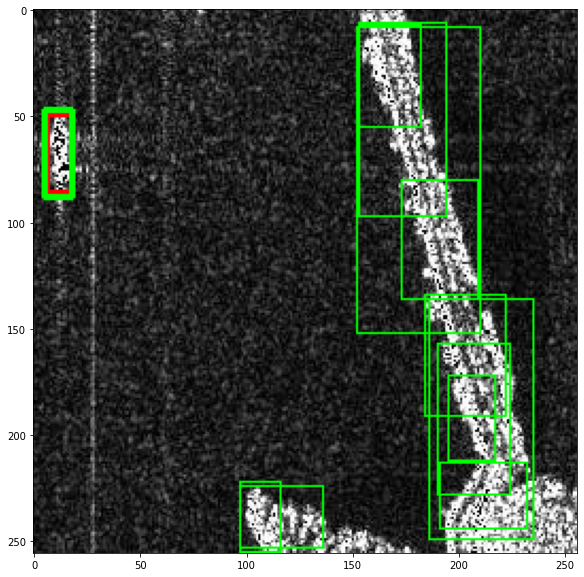

In [100]:
plot_boxes(sample, sample_boxes, sample_predicted_boxes_resnet, sample_predicted_boxes_scores_resnet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


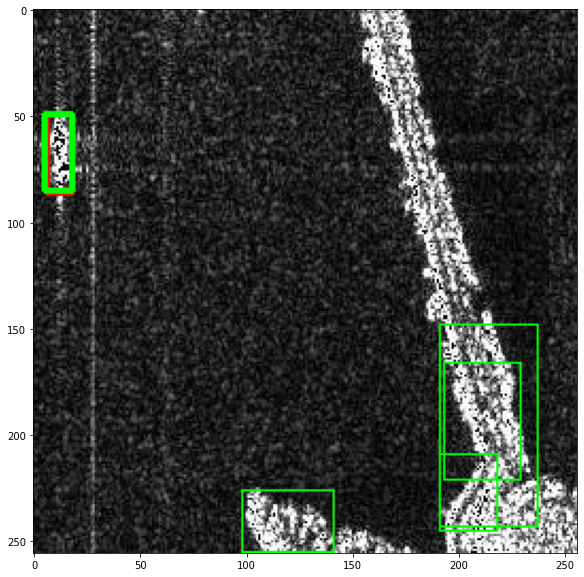

In [99]:
plot_boxes(sample, sample_boxes, sample_predicted_boxes_mobilenet, sample_predicted_boxes_scores_mobilenet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


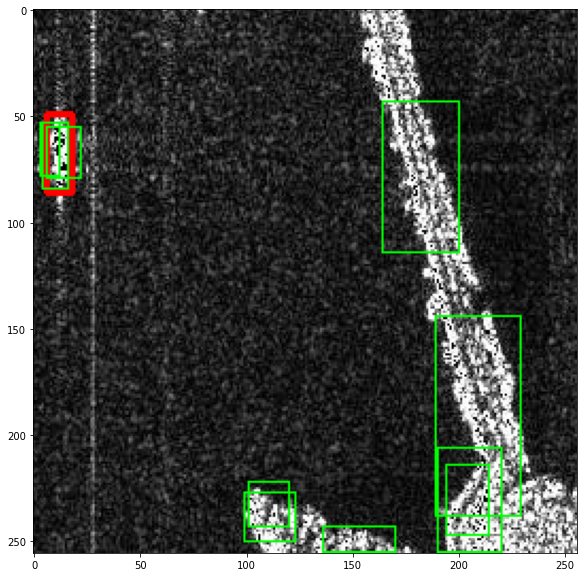

In [56]:
plot_boxes(sample, sample_boxes, sample_predicted_boxes_mobilenet_320, sample_predicted_boxes_scores_mobilenet_320)

In [57]:
#torch.save(model_resnet.state_dict(), 'resnet.pth')

#Evaluating all the models

In [58]:
targets_eval = {}
outputs_mobilenet_320_eval = {}
outputs_mobilenet_eval = {}
outputs_resnet_eval = {}

batches = 0
for images, targets, image_ids in valid_data_loader:
  batches += 1
  print(batches)

  targets_batch = get_targets_eval(image_ids, targets)
  for key, value in targets_batch.items():
    targets_eval[key] = value

  images = list(img.to(device) for img in images)

  outputs_mobilenet_320_batch = get_outputs_eval(model_mobilenet_320, images, image_ids)
  outputs_mobilenet_batch = get_outputs_eval(model_mobilenet, images, image_ids)
  outputs_resnet_batch = get_outputs_eval(model_resnet, images, image_ids)

  for key, value in outputs_mobilenet_320_batch.items():
    outputs_mobilenet_320_eval[key] = value
  for key, value in outputs_mobilenet_batch.items():
    outputs_mobilenet_eval[key] = value
  for key, value in outputs_resnet_batch.items():
    outputs_resnet_eval[key] = value

1
2


KeyboardInterrupt: ignored

In [ ]:
resnet_precisions = []
mobilenet_precisions = []
mobilenet_320_precisions = []

resnet_recalls = []
mobilenet_recalls = []
mobilenet_320_recalls = []

for threshold in np.linspace(0.5, 0.95, 10):
  evaluation_mobilenet_320 = get_avg_precision_at_iou(targets_eval, outputs_mobilenet_320_eval, False, threshold)
  evaluation_mobilenet = get_avg_precision_at_iou(targets_eval, outputs_mobilenet_eval, False, threshold)
  evaluation_resnet = get_avg_precision_at_iou(targets_eval, outputs_resnet_eval, False, threshold)

  mobilenet_320_precisions.append(evaluation_mobilenet_320['avg_prec'])
  mobilenet_precisions.append(evaluation_mobilenet['avg_prec'])
  resnet_precisions.append(evaluation_resnet['avg_prec'])

  mobilenet_320_recalls.append(np.mean(evaluation_mobilenet_320['recalls']))
  mobilenet_recalls.append(np.mean(evaluation_mobilenet['recalls']))
  resnet_recalls.append(np.mean(evaluation_resnet['recalls']))

resnet_mAP = np.mean(resnet_precisions)
mobilenet_mAP = np.mean(mobilenet_precisions)
mobilenet_320_mAP = np.mean(mobilenet_320_precisions)

resnet_AR = np.mean(resnet_recalls)
mobilenet_AR = np.mean(mobilenet_recalls)
mobilenet_320_AR = np.mean(mobilenet_320_recalls)

In [ ]:
print("mAP@[.5:.95] for resnet FPN: ", resnet_mAP)
print("mAP@[.5:.95] for mobilenet FPN: ", mobilenet_mAP)
print("mAP@[.5:.95] for mobilenet320 FPN: ", mobilenet_320_mAP)
print("\n")
print("Average recall for resnet FPN: ", resnet_AR)
print("Average recall for mobilenet FPN: ", mobilenet_AR)
print("Average recall for mobilenet320 FPN: ", mobilenet_320_AR)

mAP@[.5:.95] for resnet FPN:  0.8363636363636363
mAP@[.5:.95] for mobilenet FPN:  0.8137889834641754
mAP@[.5:.95] for mobilenet320 FPN:  0.8181818181818181


Average recall for resnet FPN:  0.7585609645995769
Average recall for mobilenet FPN:  0.7268516027254199
Average recall for mobilenet320 FPN:  0.6990960768789681


In [ ]:
print(model_resnet)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#Applying the models

In [96]:
class BigImage(Dataset):

    def __init__(self, image, transforms=None):
        super().__init__()

        self.counter = 0
        self.crop(image, 256, 256)
        self.transforms = transforms

    def crop(self, im, height, width):
        self.images = list()
        imgheight=im.shape[0]
        imgwidth=im.shape[1]
        self.counter = 0
        for i in range(0,imgheight,height):
            for j in range(0,imgwidth,width):
                tile = im[j:j+width, i:i+height]
                cv2.imwrite(f"/content/{self.counter}.jpg", tile)
                self.counter += 1

    def __getitem__(self, index: int):
        image = cv2.imread(f'/content/{index}.jpg', cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB).astype(np.float32)
        image /= 255.0

        sample = {
            'image': image,
            'bboxes': [],
            'labels': []
        }
        sample = self.transforms(**sample)
        image = sample['image']

        return image

    def __len__(self) -> int:
        return self.counter

In [101]:
image = cv2.imread('/content/01.jpg', cv2.IMREAD_GRAYSCALE)
image = image[6500:9060, 15000:17560]

test_image = BigImage(image, get_valid_transform())

test_image_data_loader = DataLoader(
    test_image,
    batch_size=10, #16
    shuffle=False,
    num_workers=2, #4
)

del image

In [106]:
def visualize_output(model, data_loader):
    model.eval()
    vertical_images = list()
    for images in data_loader:
        images = list(image.to(device) for image in images)
        outputs = get_outputs(model, images)

        horizontal_images = list()
        for i in range(len(outputs)):
            predicted_boxes = outputs[i]['boxes'].cpu().detach().numpy().astype(np.int32)
            predicted_scores = outputs[i]['scores'].cpu().detach().numpy()
            horizontal_images.append(img_with_boxes(images[i].permute(1,2,0).numpy(), [], predicted_boxes, predicted_scores))
        vertical_images.append(cv2.vconcat(horizontal_images))
    full_image = cv2.hconcat(vertical_images)

    plt.figure(figsize=(32,20))
    plt.imshow(full_image)
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

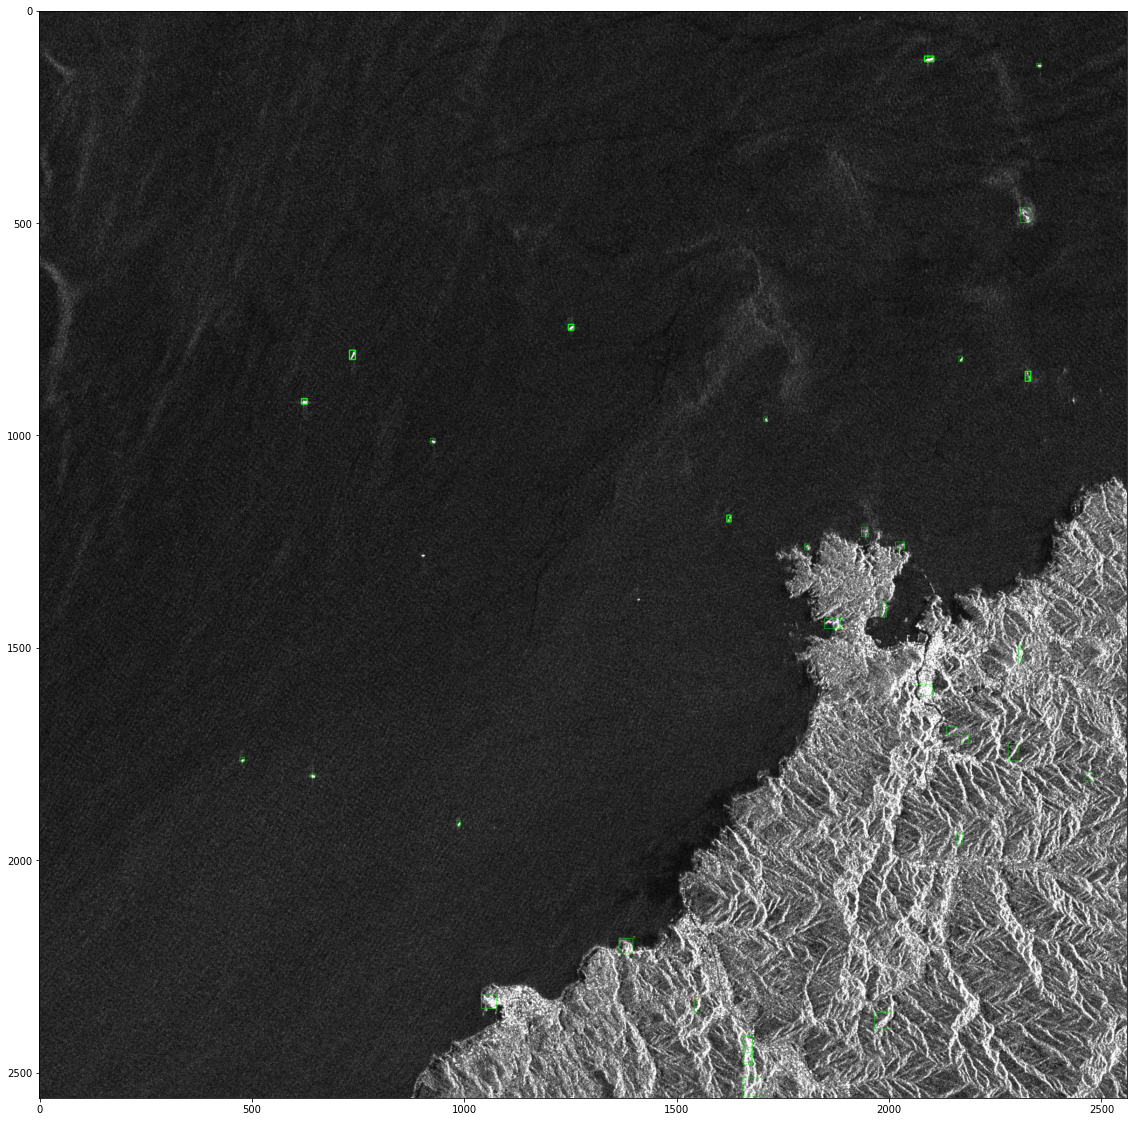

In [107]:
visualize_output(model_resnet, test_image_data_loader)